<a href="https://colab.research.google.com/github/dfabrega2021/hello-world/blob/main/Day%205/%5BDATA-05E%5D%20Example%20-%20Bay%20Wheels%20operations%20data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [DATA-05E] Example - Bay Wheels operations data

## Introduction

**Bike sharing systems** are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout an urban area. Using these systems, people are able to rent a bike from one location and return it to a different place on an as-needed basis. According to PBSC Urban Solutions, there were, as of August 2021, nearly 10 million shared bikes and 3,000 bike sharing systems across the world.

There is a great interest in these systems due to their important role in traffic, environmental and health issues. Apart from interesting real world applications of bike sharing systems, the characteristics of the data generated by these systems makes them attractive for researchers. Opposed to other transport services such as bus or subway, the duration of travel, departure location, arrival location and time elapsed is explicitly recorded. This feature turns a bike sharing system into a virtual sensor network, which can be used for studying mobility within the area. Hence, it is expected that most of important events in the area could be detected via monitoring these data.

This example uses two years of data from the **Bay Wheels Bike Share Program**, which brings point-to-point bike sharing to Bay Area cities, serving Berkeley, Emeryville, Oakland, San Jose and San Francisco. Bay Wheels is a partnership between MTC, the five local governments, and Motivate (a subsidiary of Lyft).  

The Bay Wheels Program has undergone a bit of change. It started as the Bay Area Bike Share in August 2013. On June 28, 2017, the system was officially re-launched as Ford GoBike in a partnership with Ford Motor Company. After Motivate's acquisition by Lyft, the system was renamed to Bay Wheels on June 11, 2019. In 2018, Ford GoBike added **electric bicycles** and **dockless bike share**. Nowadays, electric bicycles account for two thirds of the rides. Classic bikes are docked, so they are picked at one station and left at another station (or at the same one). E-bikes can use the **docking stations** or can be locked to a **city bike rack**.

## The data set

The data for the example come in two tables. The table `bay_stations` (a CSV file) contains data on 642 docking stations. These stations are not the same along the three-year period, since the organization is dynamic. The columns are:

* `station_id`, a unique identifier of the station. The first two characters indicate the location, with values 'BK' (Berkeley), 'SF' (San Francisco), 'SJ' (San Jose) and 'OK' (Oakland).

* `station_name`, the name of the station, referred to its location.

* `station_latitude`, the latitude of the station, with three decimals.

* `station_longitude`, the longitude of the station, with three decimals.

The table `bay_rides` (five zipped CSV files) contains information on all rides starting in the years 2021, 2022 and 2023, a total of 7,162,392 rides. The columns are:

* `user_type`, either 'casual' or 'member'.

* `bike_type`, either 'classic' or 'electric'.

* `start_time`, when the bike was picked, as yyyy-mm-dd hh:mm:ss.

* `start_station_id`, the identifier of the docking station where the ride started, missing when no station was involved.

* `end_time`, when the bike was returned, as yyyy-mm-dd hh:mm:ss.

* `end_station_id`, the identifier of the docking station where the ride ended, missing when no station was involved.

## Questions

Q1. Add a new column, `hour`, to the table `rides`, containing the hour of the start time, in `datetime64` format. Example: the hour for `2021-01-01 01:20:23` will be `2021-01-01 01:00:00`.

Q2. **Group by** `hour` and **aggregate** the data so that you get a a new table with two columns, `casual` and `member`, containing, for every hour, the total number of rides of the types of users.

Q3. After aggregating the data in the preceding question, can see you see a **time trend** in the number of rides? To visualize the trend, would it be better to aggregate more, *e.g*. to use daily data? Do you see a similar trend for the two user types?

Q4. Can you describe in an easy way the pattern for **intraday variation** (across hours) of the number of rides? Is this pattern different for the two user types?

Q5. Same questions for **intraweek variation** (across weekdays).

Q6. What about **monthly seasonality**?

## Importing the data

We import Pandas as usual.

In [49]:
import pandas as pd

The table `rides` has been split in five data sets stored in zipped CSV files in GitHub, with a common path. So, we create a variable containing that path.

In [50]:
path = 'https://raw.githubusercontent.com/MCanela-1954/Data/main/'

Next, we import the data from every files to a data frame.

In [51]:
rides1 = pd.read_csv(path + 'bay_rides-1.csv.zip')
rides2 = pd.read_csv(path + 'bay_rides-2.csv.zip')
rides3 = pd.read_csv(path + 'bay_rides-3.csv.zip')
rides4 = pd.read_csv(path + 'bay_rides-4.csv.zip')
rides5 = pd.read_csv(path + 'bay_rides-5.csv.zip')

With the Pandas function `concat()`, we can get the **union** of these five data sets as a single data frame.

In [52]:
rides = pd.concat([rides1, rides2, rides3, rides4, rides5])

## Exploring the data

We check the content of the data frame `rides` as in other examples, with the methods `.info()` and `.head()`. Everything is as expected. Note that the station ID is missing for some of the electric bikes, as explained in the introduction.

In [53]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7162392 entries, 0 to 1162391
Data columns (total 6 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   user_type         object
 1   bike_type         object
 2   start_time        object
 3   start_station_id  object
 4   end_time          object
 5   end_station_id    object
dtypes: object(6)
memory usage: 382.5+ MB


In [54]:
rides.head()

,user_type,bike_type,start_time,start_station_id,end_time,end_station_id
0,casual,electric,2021-01-01 00:01:01,NaN,2021-01-01 00:31:31,NaN
1,member,classic,2021-01-01 00:01:11,SF-I24,2021-01-01 00:21:46,SF-L29
2,member,electric,2021-01-01 00:01:44,NaN,2021-01-01 01:01:05,NaN
3,casual,electric,2021-01-01 00:03:44,SF-G30-1,2021-01-01 00:44:51,NaN
4,casual,electric,2021-01-01 00:05:33,NaN,2021-01-01 00:22:02,NaN


## Q1. Add a column with the hour

The start and end times have type `str`, so we can create the new column by means of string methods. There are many ways to do this. A simple one is to drop the last six characters, which are the minutes and seconds, and to append instead the string `':00:00'`.

In [55]:
rides['hour'] = rides['start_time'].str[:-6] + ':00:00'
rides.head()

,user_type,bike_type,start_time,start_station_id,end_time,end_station_id,hour
0,casual,electric,2021-01-01 00:01:01,NaN,2021-01-01 00:31:31,NaN,2021-01-01 00:00:00
1,member,classic,2021-01-01 00:01:11,SF-I24,2021-01-01 00:21:46,SF-L29,2021-01-01 00:00:00
2,member,electric,2021-01-01 00:01:44,NaN,2021-01-01 01:01:05,NaN,2021-01-01 00:00:00
3,casual,electric,2021-01-01 00:03:44,SF-G30-1,2021-01-01 00:44:51,NaN,2021-01-01 00:00:00
4,casual,electric,2021-01-01 00:05:33,NaN,2021-01-01 00:22:02,NaN,2021-01-01 00:00:00


We need to convert this new column to a datetime type, in order to be able to extract the weekdays. **Type conversions** in Pandas are easily managed with the method `.astype()`.

In [56]:
rides['hour'] = rides['hour'].astype('datetime64[ns]')
rides.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7162392 entries, 0 to 1162391
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   user_type         object        
 1   bike_type         object        
 2   start_time        object        
 3   start_station_id  object        
 4   end_time          object        
 5   end_station_id    object        
 6   hour              datetime64[ns]
dtypes: datetime64[ns](1), object(6)
memory usage: 437.2+ MB


## Q2. Aggregate to hourly data

To build the data set for this question we need two additional columns, `casual` and `member`. We create them as dummies, so that we can aggregate them in order to get the number of rides for each group.

In [57]:
rides['casual'] = (rides['user_type'] == 'casual')
rides['member'] = (rides['user_type'] == 'member')

Now, we group by hour and aggregate with the function `sum()`. To get a cleaner picture, we include only the columns that are relevant for the rest of this example. Note the double bracketing, which is needed, since the columns included have to be specified as a list.

In [58]:
df = rides[['hour', 'casual', 'member']].groupby(by='hour').sum()
df.head()

,casual,member
hour,,
2021-01-01 00:00:00,39,21
2021-01-01 01:00:00,48,27
2021-01-01 02:00:00,41,9
2021-01-01 03:00:00,18,7
2021-01-01 04:00:00,12,4


Note that `hour` is no longer a column, but the index. This is the default of the method `.groupby()`. Because of the type conversion performed above, to data type `datetime64`, this index is a `DatetimeIndex`.

In [59]:
df.index

DatetimeIndex(['2021-01-01 00:00:00', '2021-01-01 01:00:00',
               '2021-01-01 02:00:00', '2021-01-01 03:00:00',
               '2021-01-01 04:00:00', '2021-01-01 05:00:00',
               '2021-01-01 06:00:00', '2021-01-01 07:00:00',
               '2021-01-01 08:00:00', '2021-01-01 09:00:00',
               ...
               '2023-12-31 14:00:00', '2023-12-31 15:00:00',
               '2023-12-31 16:00:00', '2023-12-31 17:00:00',
               '2023-12-31 18:00:00', '2023-12-31 19:00:00',
               '2023-12-31 20:00:00', '2023-12-31 21:00:00',
               '2023-12-31 22:00:00', '2023-12-31 23:00:00'],
              dtype='datetime64[ns]', name='hour', length=26277, freq=None)

## Q3. Time trend

We get rid of the index name, so that it will not appear in the plots below, which might be confusing.

In [60]:
df.index.name = None

For clarity, we create a new column with the total number of rides.

In [61]:
df['total'] = df['member'] + df['casual']

Time trends are typically spotted by means of **line charts**. See below a sample using the hourly total number of rides.

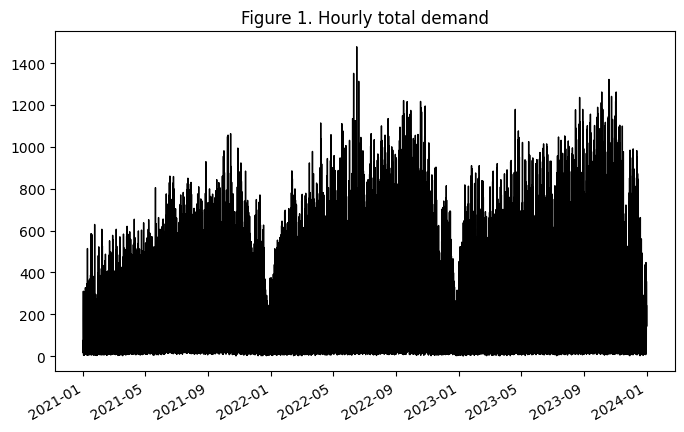

In [62]:
df['total'].plot(figsize=(8,5), title='Figure 1. Hourly total demand', color='black', linewidth=1);

We see here a combination of a trend with time-based patterns, but it is difficult to conclude much with so many observations and the current granularity of the data. Since intraday patterns can be responsible for a significant part of the variation that we see in the chart, we aggregate to a daily data set. We use the mean so the vertical scale in the successive charts remains the same. Note that, here, we don't use `.groupby()`, but `.resample()`, and we don't need to create a new data set for plotting.

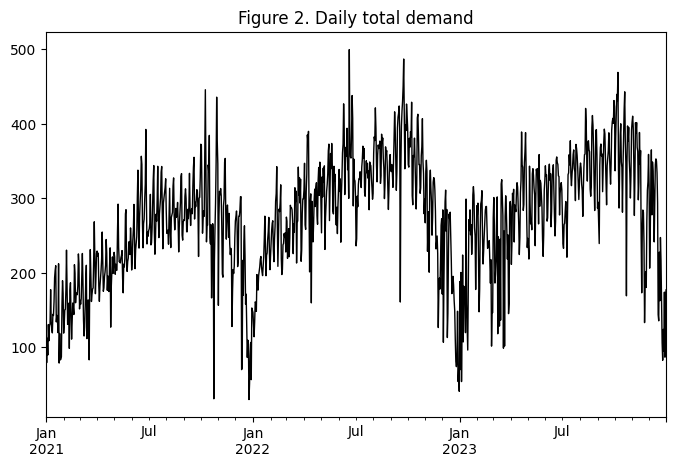

In [63]:
df['total'].resample('D').mean().plot(figsize=(8,5), title='Figure 2. Daily total demand',
	color='black', linewidth=1);

Now, the picture is more clear, though part of the variation is probably due to weekends and holidays. Going a bit further, we can aggregate to a weekly data set, again with `.resample()`.

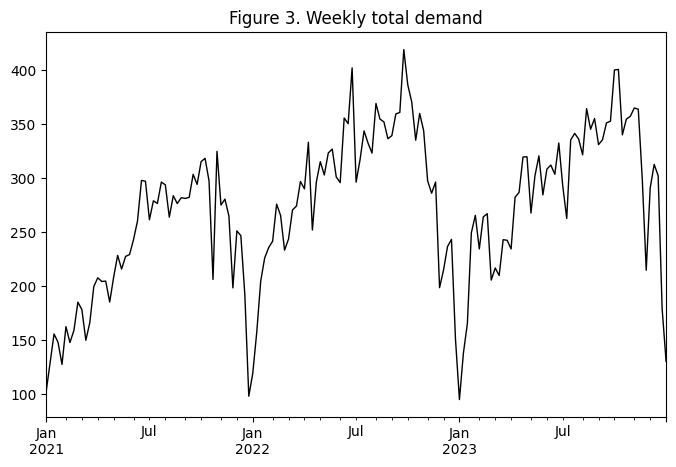

In [64]:
df['total'].resample('W').mean().plot(figsize=(8,5), title='Figure 3. Weekly total demand',
	color='black', linewidth=1);

We can aggregate the data even further, to a monthly data set. The new chart shows a combination of a trend plus monthly seasonality.

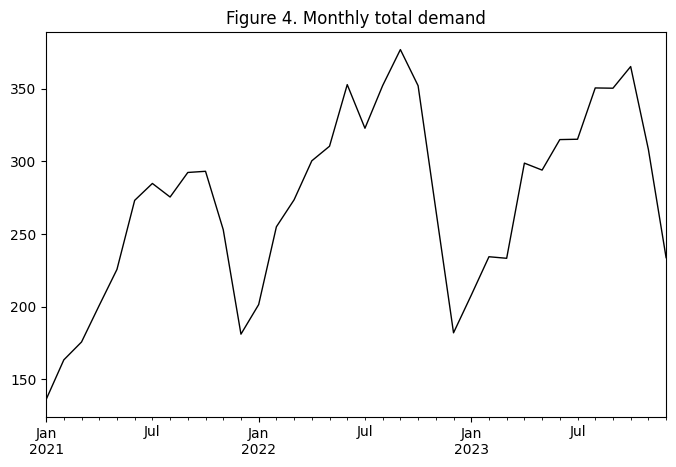

In [65]:
df['total'].resample('ME').mean().plot(figsize=(8,5), title='Figure 4. Monthly total demand',
	color='black', linewidth=1);

To see whether the trend is the same for the two user types, we can draw separate charts, which show that the trend only happens in the member group. This may be due to workforce discontinuing remote work and going back to office after the Stay Home order.

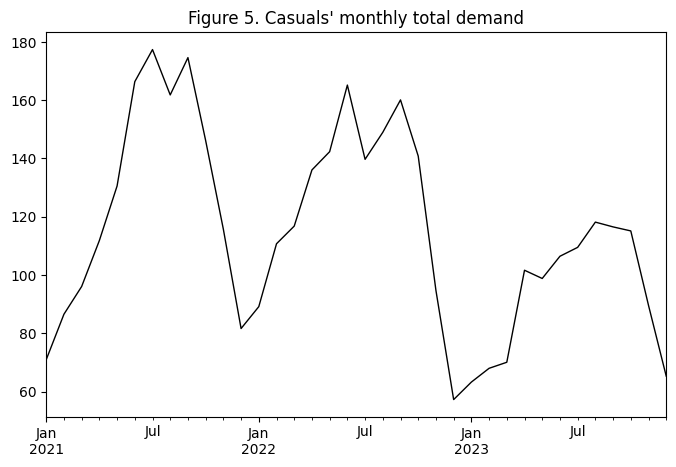

In [66]:
df['casual'].resample('ME').mean().plot(figsize=(8,5), title="Figure 5. Casuals' monthly total demand",
	color='black', linewidth=1);

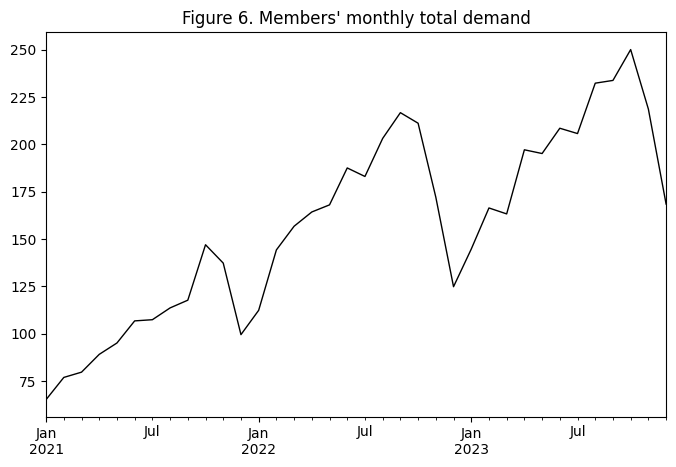

In [67]:
df['member'].resample('ME').mean().plot(figsize=(8,5), title="Figure 6. Members' monthly total demand",
	color='black', linewidth=1);

## Q4. Intraday variation

To examine the intraday variation, we need to extract an average value for every hour. First, we create a column containing (only) the hour, as an integer, with the method `.hour`.

In [68]:
df['hour'] = df.index.hour
df.head()

,casual,member,total,hour
2021-01-01 00:00:00,39,21,60,0
2021-01-01 01:00:00,48,27,75,1
2021-01-01 02:00:00,41,9,50,2
2021-01-01 03:00:00,18,7,25,3
2021-01-01 04:00:00,12,4,16,4


Now, we group by hour and aggregate to 24 average values. For the casual users, the aggregate data look like:

In [69]:
print(df[['casual', 'hour']].groupby('hour').mean().round(1))

      casual
hour        
0       34.3
1       26.3
2       19.9
3        8.5
4        8.2
5       12.3
6       28.4
7       70.5
8      126.5
9      123.3
10     130.6
11     158.2
12     184.6
13     191.4
14     201.0
15     217.8
16     242.3
17     269.9
18     228.5
19     155.1
20     101.9
21      90.6
22      79.1
23      54.7


You may prefer to see this in a **bar chart**. Comparing the charts of the two user types, we see the influence of work schedule in the intraday variation pattern of the members.  

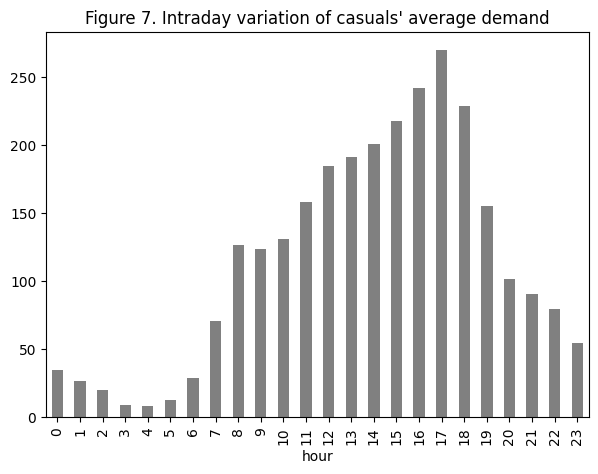

In [70]:
df[['casual', 'hour']].groupby('hour').mean().plot.bar(figsize=(7,5),
	title="Figure 7. Intraday variation of casuals' average demand", color='gray', legend=False);

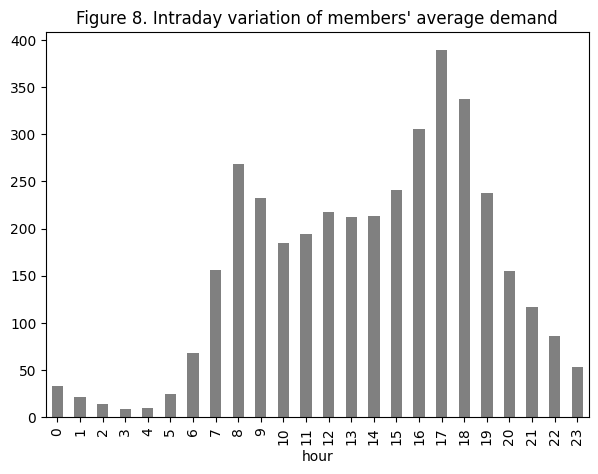

In [71]:
df[['member', 'hour']].groupby('hour').mean().plot.bar(figsize=(7,5),
	title="Figure 8. Intraday variation of members' average demand", color='gray', legend=False);

Or you may prefer to pack both charts as a **stacked bar chart**, which is easy in Pandas, as we see next.

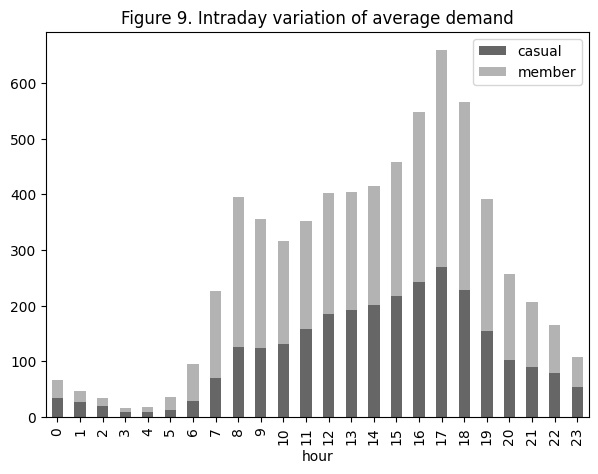

In [72]:
df[['casual', 'member', 'hour']].groupby('hour').mean().plot.bar(figsize=(7,5),
	title='Figure 9. Intraday variation of average demand', color=['0.4', '0.7'], stacked=True);

## Q5. Intraweek variation

A similar approach can be followed for the intraweek variation. First, we create a new column by extracting the weekday from the index, now with `.weekday` (Monday = 0, Sunday = 6).

In [73]:
df['weekday'] = df.index.weekday

The stacked bar chart is obtained as for question Q4. As for the intraday variation, the different patterns visualized suggest that members and casuals use the bike  travelling with different purposes (work/leisure).

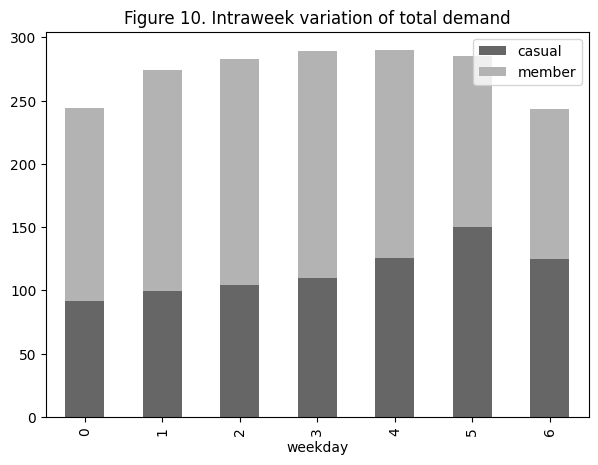

In [74]:
df[['casual', 'member', 'weekday']].groupby('weekday').mean().plot.bar(figsize=(7,5),
	title= 'Figure 10. Intraweek variation of total demand', color=['0.4', '0.7'], stacked=True);

## Q6. Monthly seasonality

We can visualize the monthly seasonality by means of twelve monthly averages. Again, we create a new column, now with months (January = 1, December = 12).

In [75]:
df['month'] = df.index.month
df[['casual', 'member', 'month']].groupby('month').mean().round(1)

,casual,member
month,,
1,74.4,107.4
2,88.4,129.2
3,94.3,133.2
4,116.5,150.2
5,123.9,152.8
6,146.0,167.6
7,142.2,165.4
8,143.0,183.0
9,150.4,189.4


We can plot just plot the total demand here, since the seasonal patterns are about the same for casuals and members.

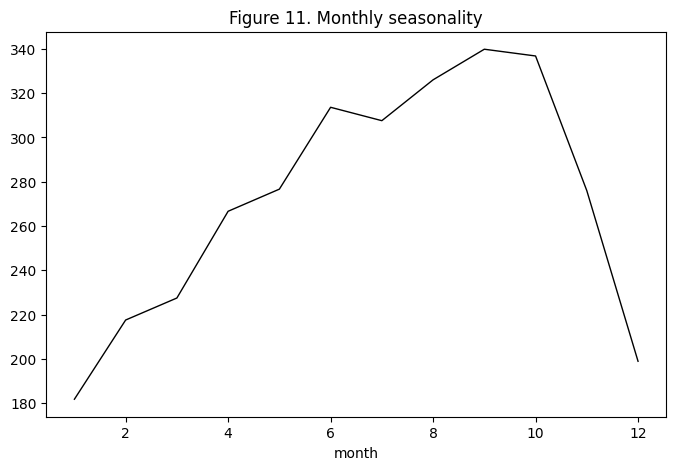

In [76]:
df[['total', 'month']].groupby('month').mean().plot(figsize=(8,5),
    title='Figure 11. Monthly seasonality', color='black', linewidth=1, legend=False);

## Homework

1. Perform an analysis of the demand in which the patterns of variation for the demand of electric and classic bikes are compared. Are classic bikes lagging behind electric bikes?

2. Check that the information about the start and end stations is missing only for electric bikes. If you take this missingness as an indication of dockless bike sharing, you can examine how dockless sharing has evolved during these three years. Would you say that dockless sharing is trending up?

3. Which are the top-10 starting stations? Are they the same as the top-10 ending stations?

4. How frequent are circular rides, starting and ending at the same station?

5. Are there stations with very low activity, so you can consider dropping them?

6. Seasonal patterns can be different across the stations of the Bay Wheels network. How can you detect the stations where the between-month variation is highest?


## Electric bikes dominate demand and show greater seasonal responsiveness.

Electric bikes consistently outperform classic bike rides in volume (Figure 1).

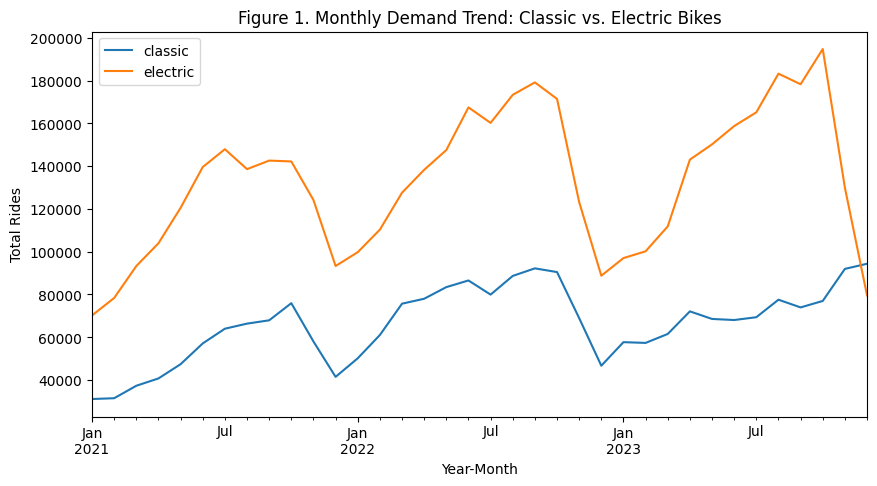

In [109]:
rides['start_time'] = pd.to_datetime(rides['start_time'])
rides['year_month'] = rides['start_time'].dt.to_period('M')

monthly_demand = rides.groupby('year_month')[['classic', 'electric']].sum()

monthly_demand.plot(
    figsize=(10, 5),
    title='Figure 1. Monthly Demand Trend: Classic vs. Electric Bikes',
    xlabel='Year-Month',
    ylabel='Total Rides'
);

In [108]:
#dummies for bike types
rides['classic'] = (rides['bike_type'] == 'classic')
rides['electric'] = (rides['bike_type'] == 'electric')

#aggregate by hour
df_bikes = rides[['hour', 'classic', 'electric']].groupby(by='hour').sum()
df_bikes['hour'] = df_bikes.index.hour
df_bikes.index.name = None
df_bikes.head()

,classic,electric,hour
2021-01-01 00:00:00,15,45,0
2021-01-01 01:00:00,12,63,1
2021-01-01 02:00:00,9,41,2
2021-01-01 03:00:00,3,22,3
2021-01-01 04:00:00,4,12,4


Figure 2 shows that electric bikes are used across all hours, and peak during the late afernoon. Classic bikes also show similar trends but at lower levels, and with relatively smaller peaks.

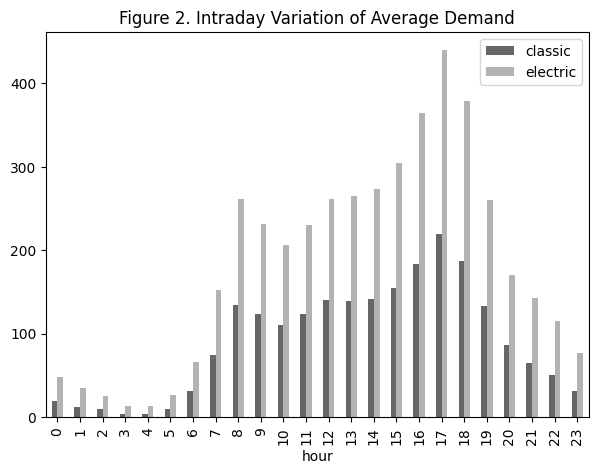

In [107]:
df_bikes[['classic', 'electric', 'hour']].groupby('hour').mean().plot.bar(figsize=(7,5),
	title='Figure 2. Intraday Variation of Average Demand', color=['0.4', '0.7'], stacked=False);

Figure 3 shows the monthly trend. Electric bikes demand grows more sharply during the summer months. While classic bikes remain relatively stable or grow marginally.

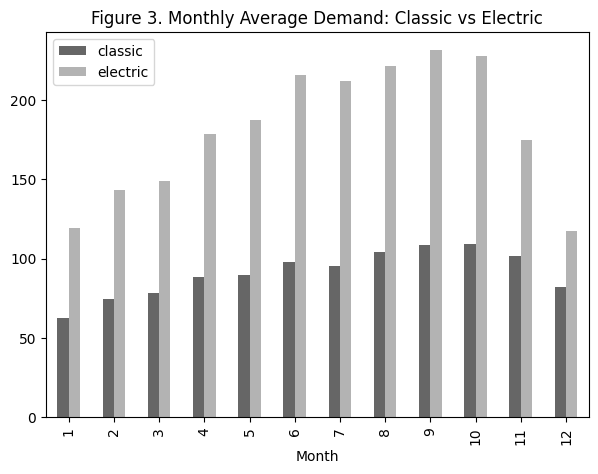

In [110]:
df_bikes['Month'] = df_bikes.index.month
monthly_bike = df_bikes.groupby('Month')[['classic', 'electric']].mean()
df_bikes[['classic', 'electric', 'Month']].groupby('Month').mean().plot.bar(figsize=(7,5),
	title='Figure 3. Monthly Average Demand: Classic vs Electric', color=['0.4', '0.7'], stacked=False);

Electric bikes dominate demand and have greater seasonal responsiveness compared to classic bikes. This trend is likely due to several factors, including the physical effort required to ride classic bikes, the higher utility of electric bikes for long-distance or hilly rides, and a post-pandemic shift in consumer preferences toward convenience.

## Dockless bike usage is rising, especially among electric bike users.

During this period, 25% to 28% of electric bikes have dockless rides.

In [80]:
na_start = rides['start_station_id'].isna()
na_end = rides['end_station_id'].isna()

print(rides.groupby('bike_type')[['start_station_id', 'end_station_id']].apply(lambda x: x.isna().mean()))

           start_station_id  end_station_id
bike_type                                  
classic            0.000000        0.000000
electric           0.247412        0.278302


Figure 4 shows that dockless ride share is increasing monthly, suggesting a growing adoption.

<Axes: title={'center': 'Figure 4. Dockless Ride Proportion by Month'}, xlabel='month'>

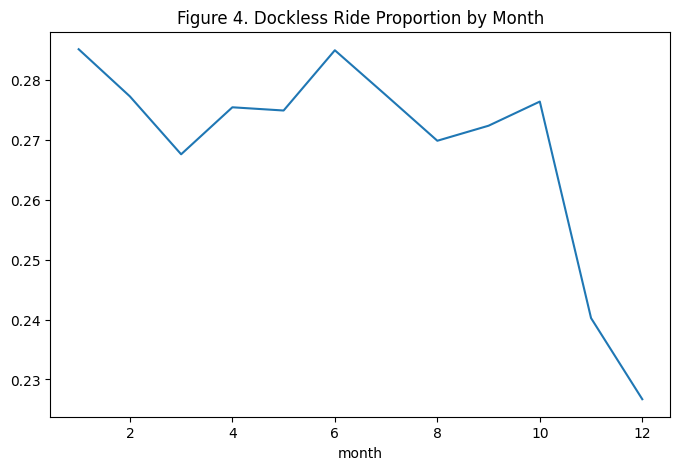

In [111]:
rides['dockless'] = rides['start_station_id'].isna() | rides['end_station_id'].isna()

rides['month'] = rides['hour'].dt.month
dockless_trend = rides.groupby('month')['dockless'].mean()
dockless_trend.plot(title='Figure 4. Dockless Ride Proportion by Month', figsize=(8,5))

Management should adapt by embracing more flexible, stationless bike-sharing models to meet rising dockless bike usage. They should focus on enhancing convenience and user satisfaction through operational adjustments and collaborate with city policymakers to plan and expand street docking infrastructure.

## Bike usage is highly centralized in San Francisco.

Nine out of the ten top start stations are also top end stations, and all of them are in San Francisco, suggesting it is the most active city in the system.


In [112]:
top_start = rides['start_station_id'].value_counts().head(10)
top_end = rides['end_station_id'].value_counts().head(10)
print("Top 10 Start Stations:\n", top_start)

print("Top 10 End Stations:\n", top_end)

Top 10 Start Stations:
 start_station_id
SF-J23-1    79918
SF-E29-2    74548
SF-G27      68196
SF-H26      55822
SF-J29      53284
SF-F28-2    48403
SF-N22-2    47426
SF-E29-1    46027
SF-K29-1    45249
SF-M20      43872
Name: count, dtype: int64
Top 10 End Stations:
 end_station_id
SF-J23-1    79146
SF-E29-2    77905
SF-G27      71552
SF-H26      57764
SF-J29      55909
SF-F28-2    51871
SF-N22-2    50859
SF-E29-1    49124
SF-K29-1    46815
SF-O22      46109
Name: count, dtype: int64


In [113]:
print("Overlap stations:", set(top_start.index) & set(top_end.index))

Overlap stations: {'SF-J29', 'SF-E29-2', 'SF-G27', 'SF-N22-2', 'SF-H26', 'SF-F28-2', 'SF-E29-1', 'SF-K29-1', 'SF-J23-1'}


This high centralization could lead to the overloading of specific stations. Therefore, management should take this into account when planning resource allocation strategies, such as rebalancing bikes, and consider adding more capacity or docks within the city to better accommodate demand.

## Circular rides make up a small portion of total trips.

Around 4.5% of all rides are circular.


In [84]:
rides['circular'] = rides['start_station_id'] == rides['end_station_id']

circular_count = rides['circular'].sum()
total_rides = len(rides)
print(f"Circular rides: {circular_count} ({circular_count / total_rides:.2%})")

Circular rides: 323116 (4.51%)


Circular rides are more frequent among casual users as this may be tourists, more likely to return to their starting point after a leisure trip. On the other hands, members, likely being commuters, tend to use bikes for point-to-point travel rather than round trips.


In [101]:
rides.groupby('user_type')['circular'].mean()

,circular
user_type,
casual,0.056656
member,0.036666


Circular rides are less likely to cause imbalances in the bike network, since bikes are returned to the start.

Some stations (e.g., LYFT-SF02 and LYFT-SF01) have extremely high proportions of circular rides, with nearly 90% of trips starting and ending at the same station. This suggests these locations are primarily used for round-trip journeys, likely serving tourists, or areas with limited nearby destinations.

In [85]:
circular_by_station = rides.groupby('start_station_id')['circular'].mean()
print(circular_by_station.sort_values(ascending=False).head())

start_station_id
LYFT-SF02    0.894231
LYFT-SF01    0.885057
SJ-G15       0.486698
SJ-M14       0.410985
SF-Z6        0.365517
Name: circular, dtype: float64


The stations with the most circular rides in total (e.g., SF-K15-, SF-A22, SF-G27) are not always the same as those with the highest proportions. These are typically high-traffic stations where, even if the proportion of circular rides is moderate, the overall volume makes them operationally significant.

In [102]:
rides[rides['circular']].groupby('start_station_id').size().sort_values(ascending=False).head(10)

,0
start_station_id,
SF-K15-,4663
SF-A22,3480
SF-G27,3417
SF-A20,3340
SF-E29-2,3261
SF-A15,3196
SF-J23-1,2944
SF-B14,2922
SF-D29,2855


Circular rides represent a small share of total trips, but are highly concentrated at a few specific locations, suggesting these areas are toursity zones where users return to their starting dock. Hence, management should prioritize these high-circular-ride locations by ensuring sufficient bike availability and dock capacity. Additionally, they might consider targeted marketing or tailored service options these areas and closely monitor usage patterns to optimize bike distribution and maintenance.

## Several stations have had almost no demand during those 3 years.

Some stations have less than 100 rides, and some even less than 10.

In [86]:
start_counts = rides['start_station_id'].value_counts()
end_counts = rides['end_station_id'].value_counts()
total_counts = start_counts.add(end_counts, fill_value=0)
low_activity = total_counts[total_counts < 100]
print("Stations with <100 rides:", low_activity)

Stations with <100 rides: GGP-L1.5    83
GGP-L1.7    51
LW1.6       56
SF-AA20     77
SF-CC18     40
SF-LW1      43
SF-LW10     10
SF-LW11     23
SF-LW12     24
SF-LW13     71
SF-LW14     16
SF-LW15      6
SF-LW2      79
SF-LW21     91
SF-LW210    27
SF-LW214    64
SF-LW215    14
SF-LW23     66
SF-LW24     35
SF-LW26     24
SF-LW27      9
SF-LW28     35
SF-LW29      8
SF-LW3       7
SF-LW4       8
SF-LW5      37
SF-LW6      12
SF-LW7      11
SF-LW8      22
SF-LW9      12
Name: count, dtype: int64


In [87]:
#percentile threshold
threshold = total_counts.quantile(0.02)

#identify stations
low_activity_percentile = total_counts[total_counts <= threshold]
print(low_activity_percentile)

SF-LW10     10
SF-LW14     16
SF-LW15      6
SF-LW215    14
SF-LW27      9
SF-LW29      8
SF-LW3       7
SF-LW4       8
SF-LW6      12
SF-LW7      11
SF-LW8      22
SF-LW9      12
Name: count, dtype: int64


 Management should prioritize evaluating the bottom 2% of stations(the 12 with the lowest usage) as they represent the least demand. These stations may be candidates for decommissioning or relocation, especially if data confirms poor placement or weak alignment with commuter flows. Cross-referencing with population density and land use data can help guide smarter redeployment decisions.

##Some stations show month-to-month high variability.

Stations like SF-E29-2, SF-J29, and SF-J23-1 show the highest month-to-month variation in ride counts. These fluctuations likely reflect seasonal factors, special events, or location-specific demand surges (e.g., near parks, tourist attractions, or event venues).


In [1]:
#stations with highest between-month variation
rides['month'] = rides['hour'].dt.month
monthly_station = rides.groupby(['start_station_id','month']).size().unstack(fill_value=0)

NameError: name 'rides' is not defined

In [89]:
variation = monthly_station.std(axis=1)

<Axes: title={'center': 'Monthly Ride Counts for Top-10 Most Variable Stations'}, xlabel='month'>

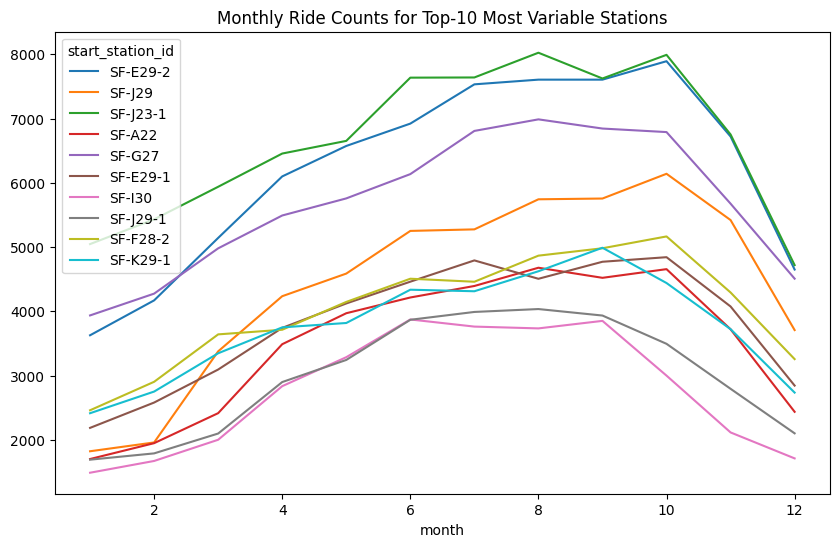

In [93]:
top10_variations = variation.sort_values(ascending=False).head(10).index

monthly_station.loc[top10_variations].T.plot(figsize=(10,6), legend=True, title='Monthly Ride Counts for Top-10 Most Variable Stations')

SF-E29-2 is the station with the highest monthly variation (standard deviation of 1470.5), followed by SF-J29 (1457.6) and SF-J23-1 (1164.8).

In [103]:
monthly = rides.groupby(['start_station_id', rides['start_time'].dt.month]).size().unstack(fill_value=0)
monthly_std = monthly.std(axis=1)
top_seasonal = monthly_std.sort_values(ascending=False).head(10)
top_seasonal

,0
start_station_id,
SF-E29-2,1470.505809
SF-J29,1457.615945
SF-J23-1,1164.832476
SF-A22,1099.549977
SF-G27,1074.114942
SF-E29-1,935.274141
SF-I30,934.881017
SF-J29-1,896.168240
SF-F28-2,851.331092


Station SF-E29-2 experiences a 2x variation between peak (summer) and low (winter) seasons. This suggests the station serves weather-sensitive or seasonal destinations.

<Axes: title={'center': 'Seasonal Variation for SF-E29-2'}, xlabel='start_time'>

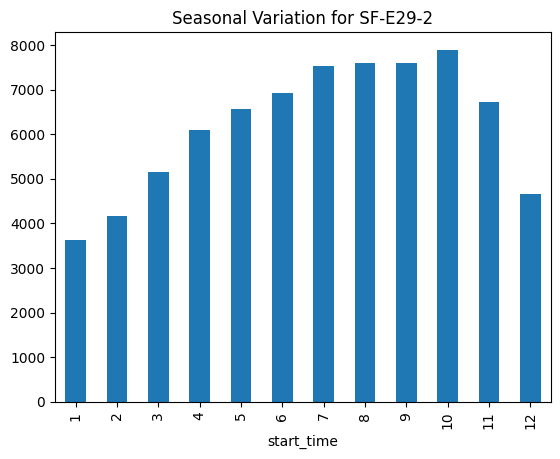

In [105]:
monthly.loc[top_seasonal.index[0]].plot(kind='bar', title=f'Seasonal Variation for {top_seasonal.index[0]}')

Management should adjust bike supply, staffing, and rebalancing throughout the year—to ensure high service quality and efficiency at stations with strong seasonal demand swings.